In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('climate-data.csv')

# Create a datetime index by specifying the year, month, and day columns
df['date'] = pd.to_datetime(df[['YEAR', 'MO', 'DY']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d')

# Set the 'date' column as the DataFrame index
df.set_index('date', inplace=True)

# Drop the original 'YEAR', 'MO', and 'DY' columns
df.drop(['YEAR', 'MO', 'DY'], axis=1, inplace=True)

# Display the modified DataFrame
print(df.head())

            pressure  windspeed  humidity   temp
date                                            
2019-01-01    101.20       4.23     11.29  22.22
2019-01-02    101.17       4.19     12.27  22.74
2019-01-03    101.22       4.13     12.51  23.23
2019-01-04    101.16       4.31     12.51  23.08
2019-01-05    101.02       4.01     12.57  23.14


In [18]:
df.tail()

,pressure,windspeed,humidity,temp,diff_pressure,diff_temp
date,,,,,,
2022-12-28,1.813701,-1.238510,-0.157297,-0.957768,0.885719,0.848912
2022-12-29,2.115691,-1.673564,-0.435385,-1.086957,1.080765,-0.542470
2022-12-30,2.252958,-1.797865,-0.961224,-1.195310,0.495626,-0.455509
2022-12-31,2.088237,-1.860015,-1.178638,-1.324500,-0.577129,-0.542470
2023-01-01,-0.821842,-1.620292,-1.153357,-1.199477,-10.329448,0.518459


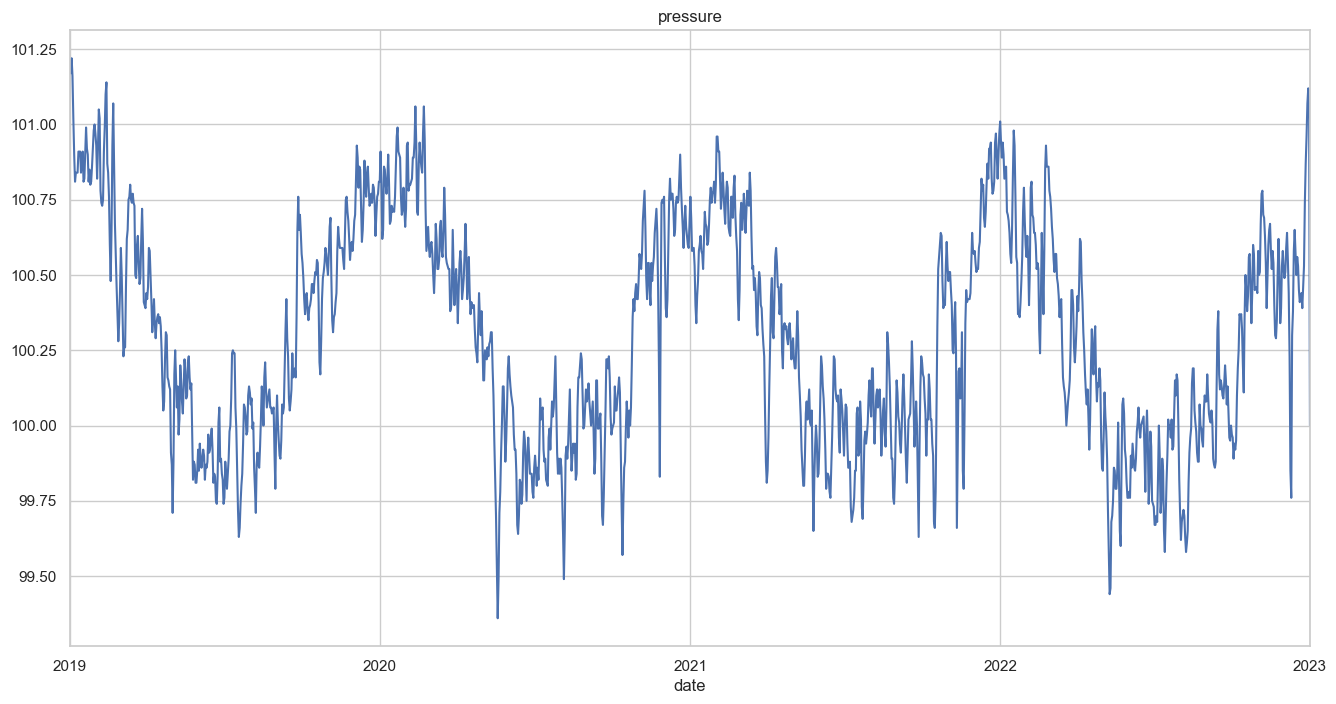

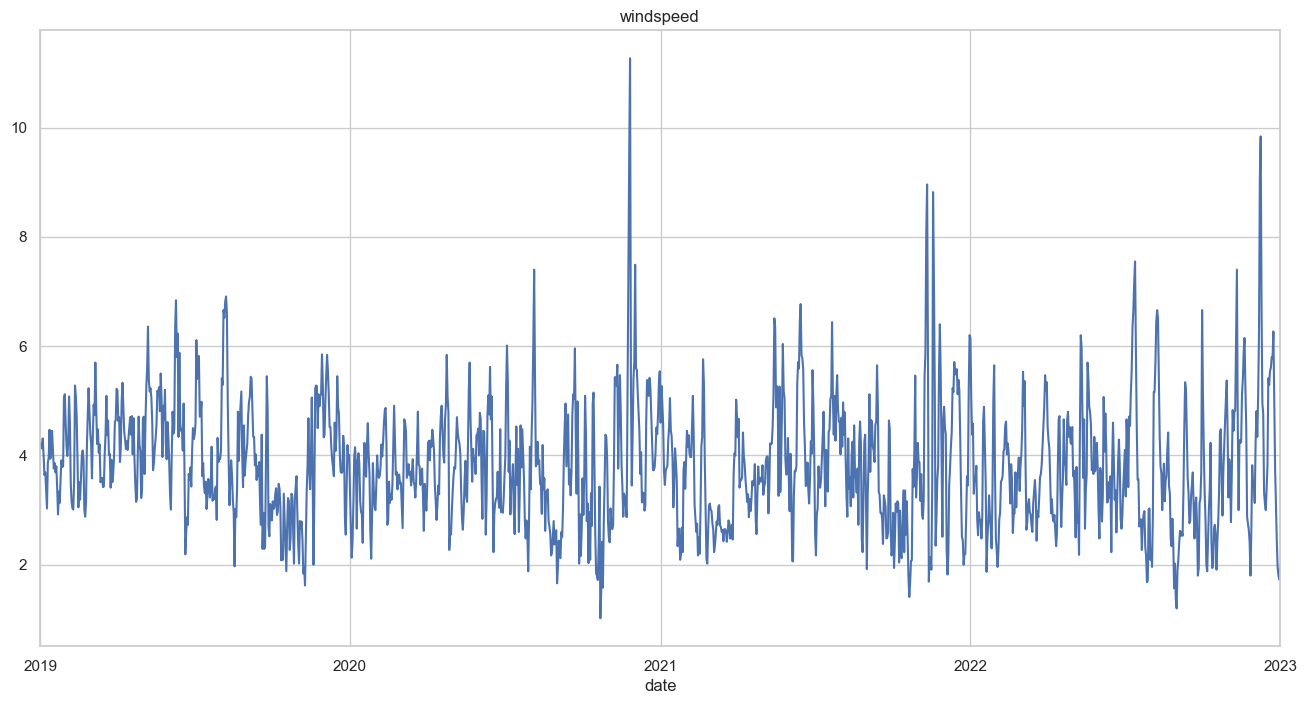

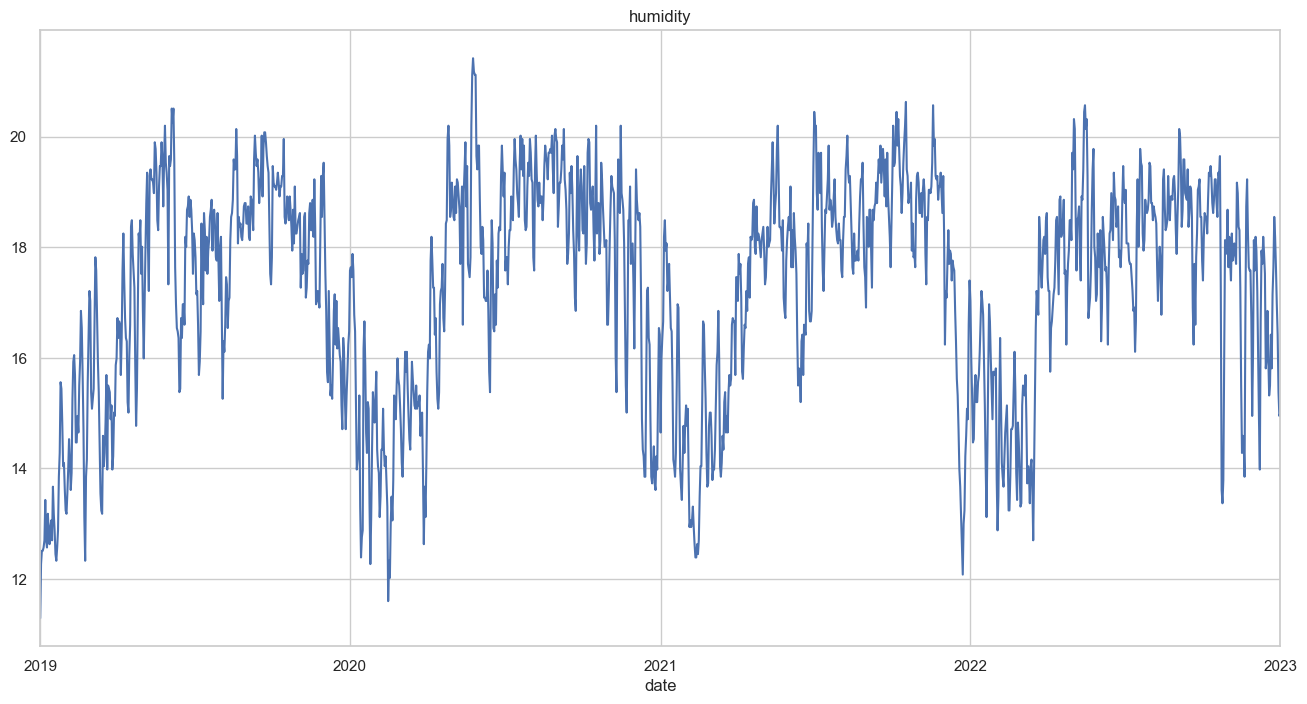

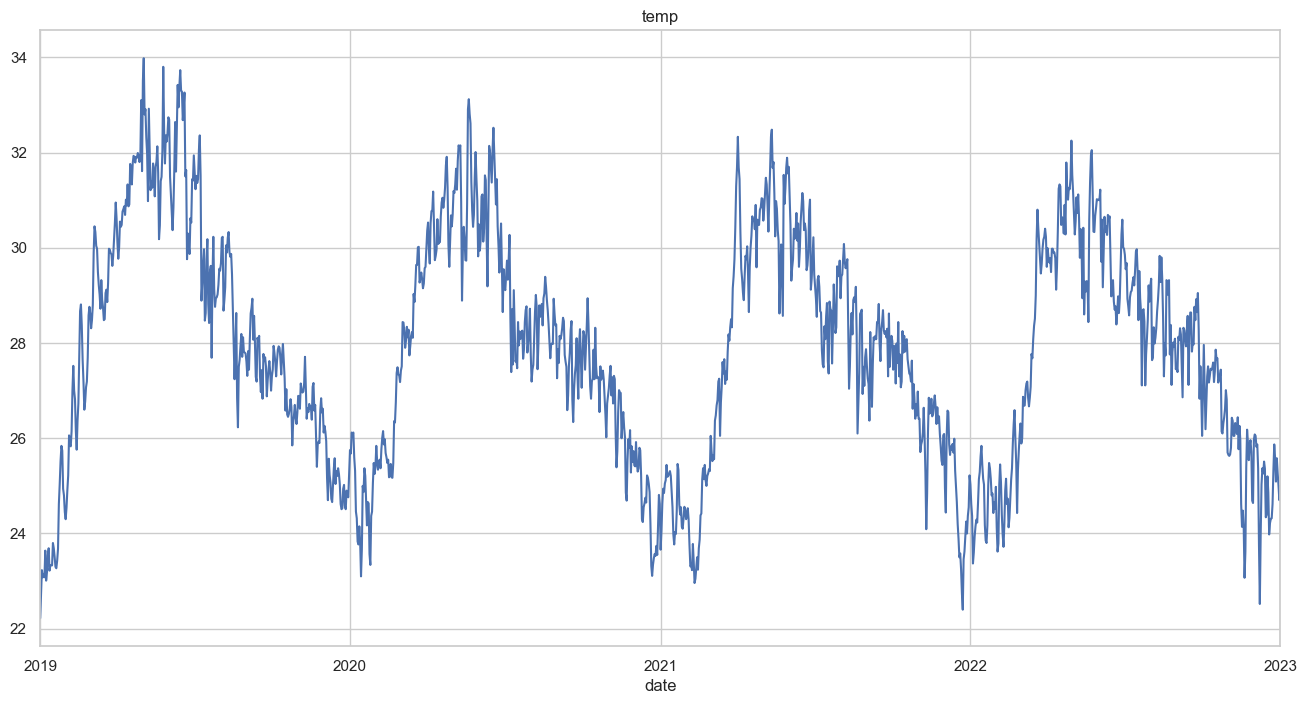

In [3]:
for cols in df.columns:
    sns.set(style = "whitegrid")
    plt.figure(figsize = (16,8))
    df[cols].plot()
    plt.title(cols)
    plt.show()

In [4]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(data):
    result=adfuller(data)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.01:
        print("Data is stationary")
    else:
        print("Data is non-stationary")

In [5]:
for cols in df.columns:
    print(f"{cols}\n")
    adfuller_test(df[cols])
    print("\n")

pressure

ADF Test Statistic : -3.2356827578738314
p-value : 0.018009927376203397
#Lags Used : 12
Number of Observations : 1449
Data is non-stationary


windspeed

ADF Test Statistic : -15.654036731999694
p-value : 1.5835084530727693e-28
#Lags Used : 1
Number of Observations : 1460
Data is stationary


humidity

ADF Test Statistic : -4.280932675759133
p-value : 0.0004792246930639155
#Lags Used : 10
Number of Observations : 1451
Data is stationary


temp

ADF Test Statistic : -2.7747794113782036
p-value : 0.06196763642863215
#Lags Used : 8
Number of Observations : 1453
Data is non-stationary




In [6]:
adfuller_test(np.diff(df['pressure'], n=1))

ADF Test Statistic : -10.752965078739567
p-value : 2.6364890096511375e-19
#Lags Used : 21
Number of Observations : 1439
Data is stationary


In [7]:
adfuller_test(np.diff(df['temp'], n=1))

ADF Test Statistic : -17.79510173859114
p-value : 3.2352216028021164e-30
#Lags Used : 7
Number of Observations : 1453
Data is stationary


In [8]:
df['diff_pressure'] = df['pressure'].diff()
df['diff_temp'] = df['temp'].diff()

In [9]:
train_mean = df.mean()
train_std = df.std()

def standardize(time_series):
    return (time_series - time_series.mean())/(time_series.std())

df = df.apply(standardize)

In [10]:
columns = ['humidity', 'windspeed','diff_temp','diff_pressure']

ts = df[columns].dropna()

In [11]:
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(ts, dates=ts.index, freq=df.index.freq)

results = model.fit(maxlags=25, ic='aic', verbose=1)

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 8, BIC -> 2, FPE -> 8, HQIC ->  3>
Using 8 based on aic criterion


F:\Applications\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [12]:
print(results.summary()._resid_info())

Correlation matrix of residuals
                 humidity  windspeed  diff_temp  diff_pressure
humidity         1.000000   0.052672   0.136607      -0.077210
windspeed        0.052672   1.000000  -0.063107      -0.187277
diff_temp        0.136607  -0.063107   1.000000      -0.217504
diff_pressure   -0.077210  -0.187277  -0.217504       1.000000




In [13]:
df_test = pd.read_csv('test-climate-data.csv')

# Create a datetime index by specifying the year, month, and day columns
df_test['date'] = pd.to_datetime(df_test[['YEAR', 'MO', 'DY']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d')

# Set the 'date' column as the DataFrame index
df_test.set_index('date', inplace=True)

# Drop the original 'YEAR', 'MO', and 'DY' columns
df_test.drop(['YEAR', 'MO', 'DY'], axis=1, inplace=True)

# Display the modified DataFrame
print(df_test.head())

            pressure  windspeed  humidity   temp
date                                            
2023-01-01    101.01       2.13     15.14  24.36
2023-01-02    100.98       3.08     14.83  24.74
2023-01-03    101.01       3.53     14.83  24.67
2023-01-04    100.93       4.13     14.89  24.68
2023-01-05    100.96       5.25     14.28  24.60


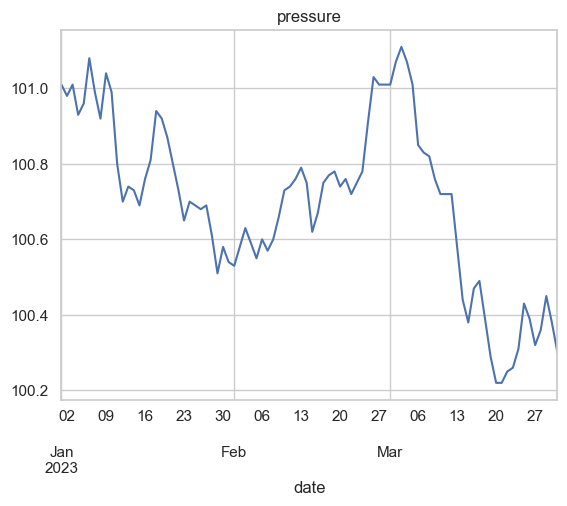

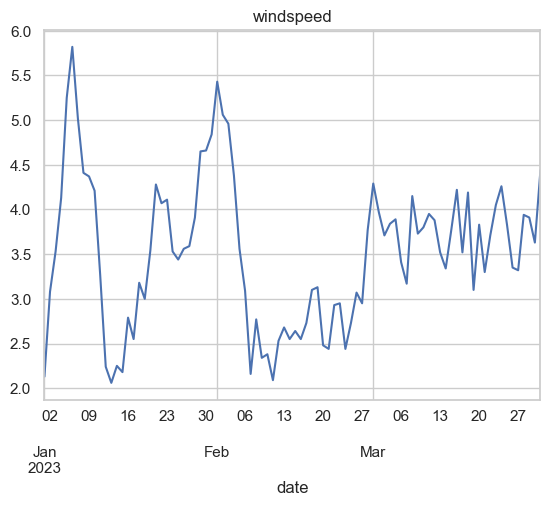

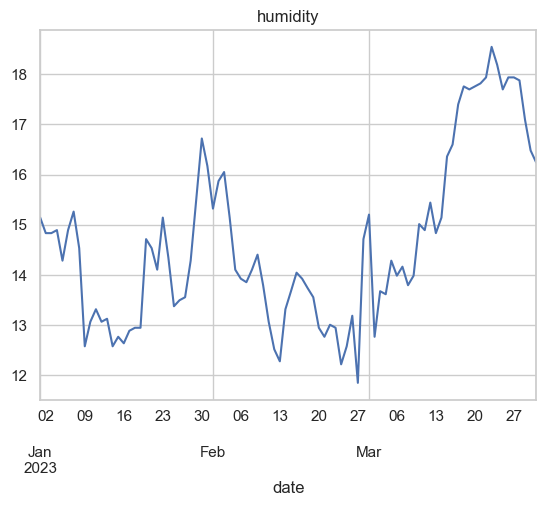

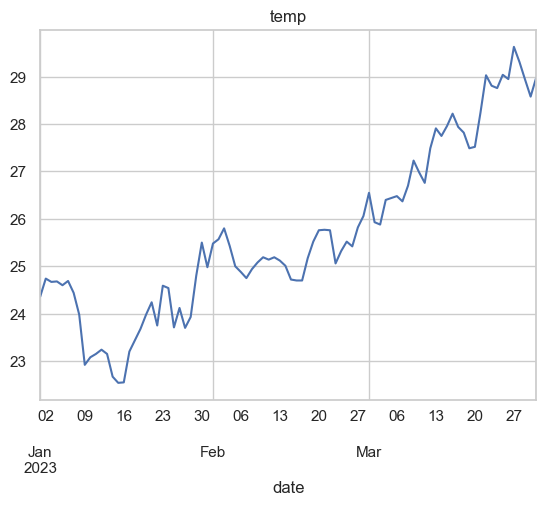

In [14]:
for cols in df_test.columns:
    sns.set(style = "whitegrid")
    #plt.figure(figsize = (16,8))
    df_test[cols].plot()
    plt.title(cols)
    plt.show()

In [15]:
df_test['diff_pressure'] = df_test['pressure'].diff()
df_test['diff_temp'] = df_test['temp'].diff()

# Drop the temperature and pressure
df_test.drop(columns = ['temp','pressure'], inplace=True)

In [16]:
for quant in df_test.columns:
    mean = train_mean[quant]
    std = train_std[quant]
    df_test[quant] = df_test[quant].apply(lambda val : (val-mean)/std)

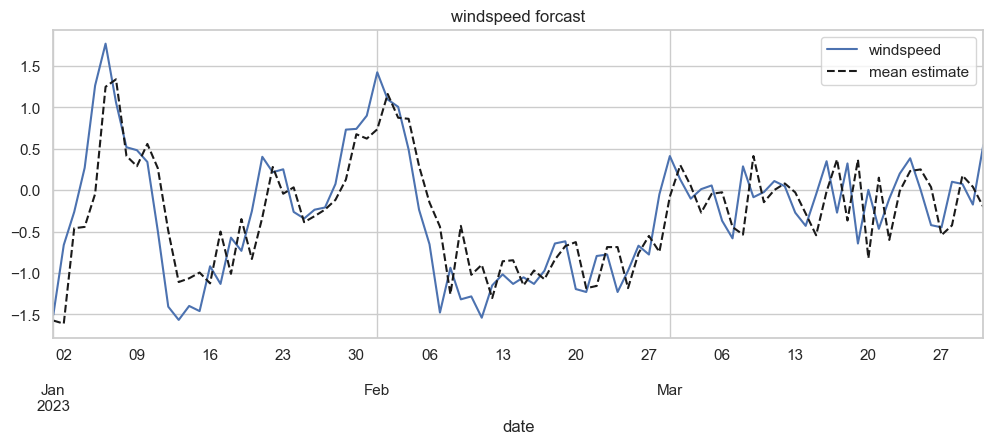

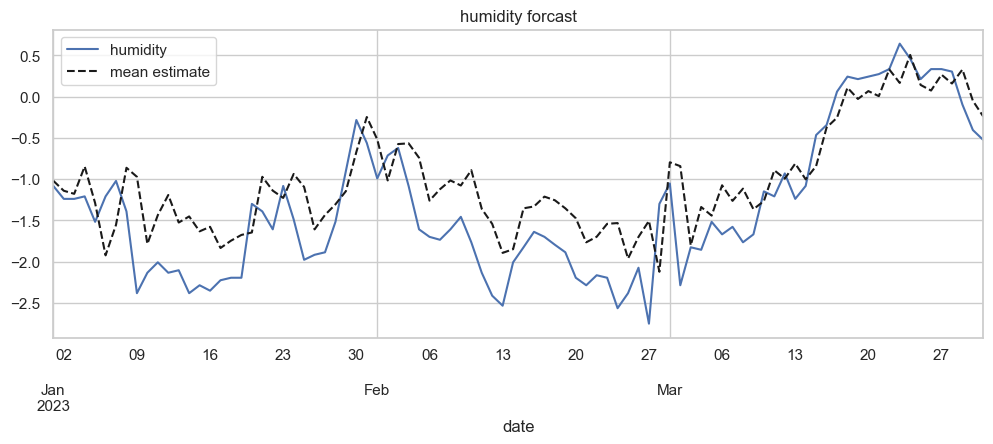

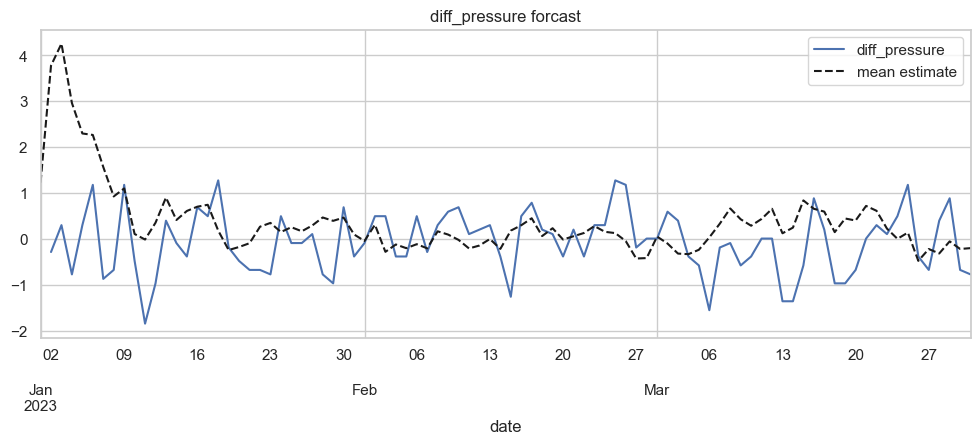

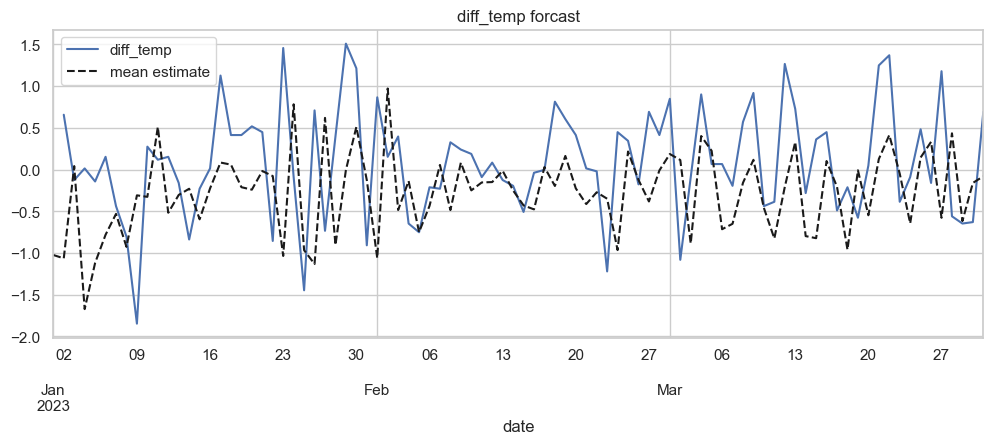

In [17]:
N_test,_ = df_test.shape

full_df = pd.concat((df[df_test.columns],df_test))
full_df.fillna(method='ffill',inplace=True)

_,p = full_df.shape

endogenous_var = full_df.to_numpy()

estimate_array = np.empty(shape=(0,p))

# Compute the forcast one step ahead
for i in range(N_test,0,-1):

    estimate,lower,upper = results.forecast_interval(y=endogenous_var[:-i],steps=1)
    
    estimate_array = np.vstack((estimate_array,estimate))    
# Plot the forcast 
for i,quant in enumerate(df_test.columns):
    df_test[quant].plot(figsize=(12,4))
    plt.plot(df_test.index,estimate_array[:,i],'k--',label='mean estimate')
    plt.legend()
    plt.title('{} forcast'.format(quant))
    plt.show()
